# Demo: Utilizing the MRS Phantom framework
This Jupyter Notebook serves as a demonstration of the MRS Phantom framework. We will walk through all the necessary steps, showcasing how to visualize and utilize the phantom for data simulation. The figure below provides an overview of the complete 3D MRS Digital Brain Phantom Framework. Each of the steps outlined in the framework will be covered in this notebook.

<figure style="text-align: center;">
    <img src="media/framework.png" alt="Sample Figure" width="600" />
    <figcaption>Figure 1: Structure of the 3D MRS Digital Brain Phantom Framework. The framework is divided into three stages: Skeleton, MRS Phantom, and Simulation. Each stage allows for user-defined inputs, making the framework highly modular and customizable for various applications.</figcaption>
</figure>

### Content

1. Preparation and folder structure
2. Generate metabolite database
3. Generate and/or load MRS Phantom
4. Visualization and properties of the phantom
5. Spectral simulation
6. MRSI downsampling and saving

**NOTE:** Before diving into the demo, it's helpful to consult the docstrings of the methods and classes used in this notebook. These docstrings provide valuable information on the functionality and parameters of each function, which can aid in understanding the implementation and usage.

## 1. Preparation and folder structure

- The data for the **BigBrain-MR phantom** can be downloaded [**here**](https://zenodo.org/records/7432527).
- Data from **MRiLab** used in this demonstration is available in this repository: [repository link].

Ensure the entire repository is downloaded and organized within the data folder following the structure below:

```
Digital_Phantom
|   Demo_MRS_Phantom.ipynb (this file)
|   ...
|___media
|___loading
|___simulation
|___utils
|___preprocessing
|___data
    └───Basissets
    └───BigBrain-MR
    └───metabolites
    └───MRiLab
    └───phantom
```

The files for the BigBrain-MR can be put directly into the corresponding folder. We downloaded all 400 $\mu m$ files. 


### Imports
Below are all the necessary imports required to run this demo notebook.

In [1]:
## Imports
# Standard libraries
import numpy as np
import os

# Own libraries
from preprocessing.preprocess_df import create_metab_df

from DigitalPhantom import DigitalPhantom

from simulation.basis import Basis
from simulation.signalModels import SignalModel
from simulation.simulation import simulate_spectra

from utils.auxillary import downsample_mrsi, save_nifti_mrsi, downsample_metab_map, save_numpy_mrsi, save_hdf5_mrsi
from utils.visualizations import plot_metabolite_map, plot_mrsi

## 2. Generate metabolite database
In this step, the metabolite database described in [1] will be filtered according to the scheme shown below:

<figure style="text-align: center;">
    <img src="media/database_filter.png" alt="Sample Figure" width="800" />
    <figcaption>Figure 2: Filtering flowchart of the metabolite database entries used. These steps are performed to select the appropriate subset of entries collected in the previous meta-analysis.</figcaption>
</figure>


Settings can be adjusted to generate a different final metabolite DataFrame (metab_df).

In [2]:
# Create metabolite dataframe
metab_df, concs_df, t2_df = create_metab_df(
            labels=['Background', 'WM', 'GM', 'CSF'],   # Tissue labels to include
            groups=['Healthy', 'Control'],              # Group labels to include
            fraction_boundary=0.6,                      # Tissue fraction boundary for GM/WM labelling
            age_range=[18, 60],                         # Age range for studies to include
            tesla=3.0,                                  # Magnetic field strength to include               
            save=True,                                  # Save created dataframe to a csv file          
)

LOADING MRS DATABASE...
Preprocess concentration dataframe...
Filtering on "['Healthy', 'Control']" group... 
          Before: Unique articles - 351, Entries - 9136 
          After : Unique articles - 291, Entries - 3812
        
Dropping entries where no information about GM/WM is present... 
          Before: Unique articles - 291, Entries - 3812 
          After : Unique articles - 100, Entries - 1412
        
Change percentages to fractions...
Assign tissue value based on GM/WM fractions (boundary: 0.6)...
Drop all entries that are not WM or GM... 
          Before: Unique articles - 100, Entries - 1412 
          After : Unique articles - 71, Entries - 847
        
Change NaN values to 0...
Select age range of 18-60 years... 
          Before: Unique articles - 71, Entries - 847 
          After : Unique articles - 54, Entries - 585
        
Remove all MM entries... 
          Before: Unique articles - 54, Entries - 585 
          After : Unique articles - 54, Entries - 585
    

We can preview the first few rows of the metabolite DataFrame (`metab_df`) to inspect its structure. While a different metabolite DataFrame can be used, it must follow the same format as shown below:

In [3]:
# Show metabolite dataframe
metab_df.head()

,Metabolite,Label,Tissue,Conc_mean,Conc_std,T1,T2
0,Asc,0,Background,0.00,0.00,0.0,0.0
1,Asc,1,WM,NaN,NaN,NaN,172.0
2,Asc,2,GM,1.41,0.16,NaN,125.0
3,Asc,3,CSF,NaN,NaN,NaN,NaN
4,Asp,0,Background,0.00,0.00,0.0,0.0


## 3. Generate and/or load MRS Phantom
At this point, all preparations have been completed to generate the MRS phantom. This is achieved using the core class of the framework: `DigitalPhantom`. All relevant information will be stored within this phantom.

In [4]:
# Create a DigitalPhantom object
phantom = DigitalPhantom(
    # General settings
    skeleton='MRiLab',                        
    resolution=3.0,                                    
    path2phantom='./data/phantom/',            
    from_scratch=False,                     
    # Metabolite settings
    concs_std=0.05,                         
    # Lipid settings
    sigma_lipid_spread=3.5,                     
    # Gradient settings
    grad_metabs=['NAA'], 
    grad_settings=[0.5, 3, '+y']
    )

Initializing Digital Phantom...
Phantom found at "./data/phantom/MRiLab/3.0mm". Loading phantom...
Phantom loaded!


## 4. Visualization and properties of the phantom
We can quickly obtain a summary of the phantom by extracting its information as follows:

In [5]:
# Print Phantom information
phantom.get_phantom_info()

###############################
Digital Phantom Information:
  - Skeleton: MRiLab
  - Resolution: 3.0 mm
  - Metabolite Data Shape: (60, 72, 60, 21, 4)
  - Metabolite Data Info: {'DIM_1': 'x', 'DIM_2': 'y', 'DIM_3': 'z', 'DIM_4': 'metabolite_id', 'DIM_5': 'metabolite_info'}
  - Metabolite Dimension Info: {'0': 'metabolite_id', '1': 'conc', '2': 't1', '3': 't2'}
  - Metabolite Mapping: {'Asc': 0, 'Asp': 1, 'Cr': 2, 'GABA': 3, 'Glc': 4, 'Gln': 5, 'Glu': 6, 'Gly': 7, 'GPC': 8, 'GSH': 9, 'H2O': 10, 'Lac': 11, 'mI': 12, 'NAA': 13, 'NAA_Asp': 14, 'NAAG': 15, 'PCh': 16, 'PCr': 17, 'PE': 18, 'sI': 19, 'Tau': 20}
  - Lipid Map Available: True
    - Lipid Bleed: 3.5
  - Gradient Applied: True
    - Gradient Direction: +y
    - Gradient Max Value: 3
    - Gradient Min Value: 0.5
###############################


We can also extract the metabolite maps and visualize them as follows:

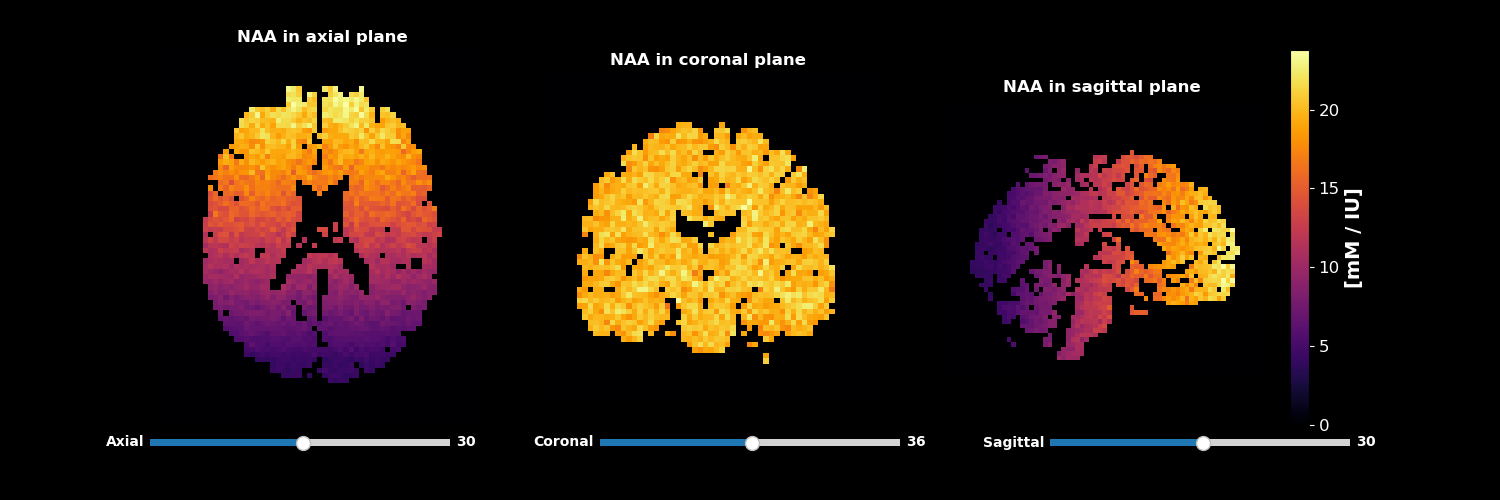

In [6]:
# Make sure plots can be used interactively
%matplotlib widget

# Select a metabolite, create the map, and plot it
metab_name = 'NAA'
metab_map = phantom.create_metab_map(metab=metab_name)
fig, axs = plot_metabolite_map(metab_map, metab_name, cmap='inferno', vmin=None, vmax=None, slice_idxs=None)



## 5. Spectral simulation
Using the phantom, MRSI data can be generated. To do this, a basis set must be loaded, and a signal model is required to process the phantom's metabolite data. Currently, a Voigt signal model is implemented, based on FSL-MRS[2]. The `simulate_spectra` function utilizes both the phantom and the signal model to run the simulation in a batch-wise manner. It also includes an argument to specify the slice numbers (`slice_range`) to be simulated. The output consists of the ppm axis and a matrix containing all spectra.

Metabolites will only be simulated if all the necessary entries in the metabolite DataFrame are populated. Specifically, both $T_2$ concentrations and metabolite concentrations must be provided. If any required information is missing, the signal model will assign zero values for that metabolite.

In [7]:
path2basis = './data/Basissets/3T/Philips_TE30_PRESS_pMMupdated.mat'

phantom_metabs = list(phantom.metab_mapping.keys())

basis = Basis(path2basis, fmt='osprey', bw=2000, points=2048, metabs=[], phantom_metabs=phantom_metabs)
signalModel = SignalModel(basis, gauss_broadening=15, freq_shift=0, mm_scale=1000, noise_std=1000, res_water_scale=5, lipid_scale=10, baseline_order=2, baseline_scale=400)
  
ppm_axis, spectra = simulate_spectra(phantom, basis, sigModel=signalModel, metabs=[], slice_range=[25,35], batch_size=1000)

print(f"\nSize of the simulated spectra: {spectra.shape}")

There are metabolites in the data that are not present in the basis: ['Glc', 'NAA_Asp']
Removing these metabolites from the data...
Simulating spectra for 21496 voxels...


100%|██████████| 22/22 [00:27<00:00,  1.26s/it]

Spectral simulation completed!

Size of the simulated spectra: (60, 72, 60, 2048)


### Plot simulated data
We can visualize the simulated data alongside a metabolite map of your choice. The resolution of the simulated data matches the resolution of the MRS Phantom.

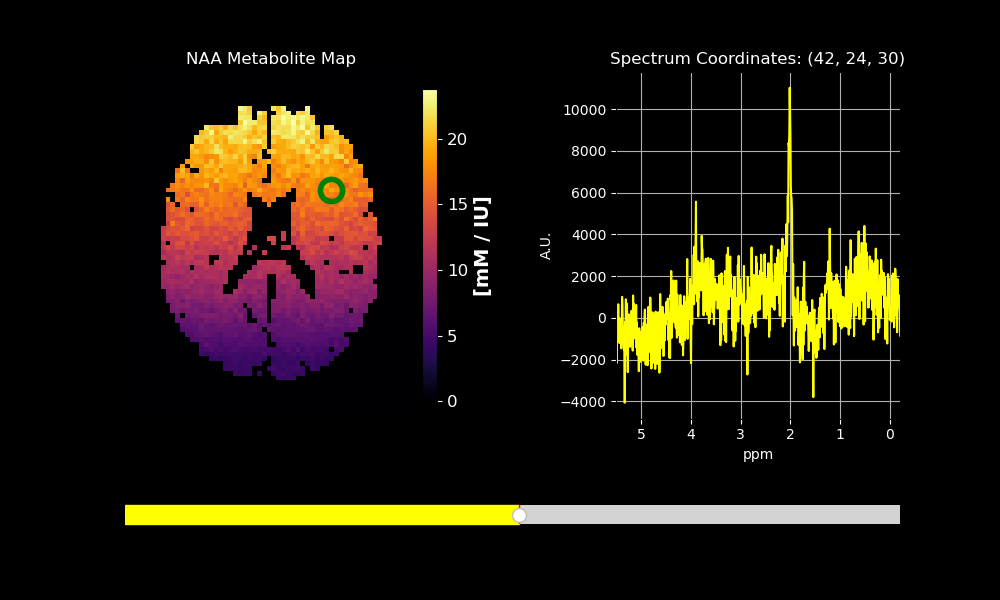

In [8]:
# Make sure plots can be used interactively
%matplotlib widget

# Plot the MRSI data with the NAA metabolite map
metab_map = phantom.create_metab_map(metab='NAA')
fig, axs = plot_mrsi(spectra, metab_map, ppm_axis, metab_name='NAA', start_x=42, start_y=24)

## 6. MRSI downsampling and saving

The simulated MRSI data can be downsampled and saved using the methods outlined below. First, the simulated data is saved as a NumPy file. This file is then used to downsample the data to the target resolution. The downsampling process ensures that the new resolution is an integer multiple of the original resolution and meets or exceeds the target resolution (`target_resolution`). Finally, the downsampled data is saved in the NIfTI-MRS format [3] for further analysis and use.

**NOTE:** Be aware of setting the save directory (`save_dir`) to a location with sufficient free space. Simulating all slices for the 1mm resolution phantom can take up to +100 GB.

In [9]:
# Save HDF5 file
save_dir = '/Volumes/Samsung_T7/data/Digital_Brain_Phantom'
os.makedirs(save_dir, exist_ok=True)

save_name = 'mrsi_simulated_DEMO'
file_name = save_hdf5_mrsi(spectra, save_dir, save_name, phantom)

# Downsample and save nifti-mrsi
target_resolution = (6.0, 6.0, 6.0)
path2save = os.path.join(phantom.path2phantom, 'mrsi')
os.makedirs(path2save, exist_ok=True)
reduced_data, new_affine = downsample_mrsi(file_name, phantom.affine, target_resolution=target_resolution)
save_nifti_mrsi(reduced_data, basis, new_affine, etime=35, rtime=1.0, path2save=path2save, save_name='DEMO_RUN')

Saving MRSI data as HDF5 file to /Volumes/Samsung_T7/data/Digital_Brain_Phantom/MRiLab/3.0mm/mrsi_simulated_DEMO.h5...
Saving HDF5 file done!
Starting downsampling...
Downsampling metabolic map from (3.0, 3.0, 3.0) mm to (6.0, 6.0, 6.0) mm using block averaging...
[########################################] | 100% Completed | 10.39 ss
Downsampling completed!
Saving mrs-nifti file...
Done!


### Plot MRSI on downsampled scale
We can visualize the saved, downsampled data using the same visualization methods as for the high-resolution data. To do this, we simply need to downsample the metabolite map as well:

Starting metabolic map downsampling...
Downsampling metabolic map from (3.0, 3.0, 3.0) mm to (6.0, 6.0, 6.0) mm using block averaging...
[########################################] | 100% Completed | 105.94 ms
Metabolic map downsampling completed!


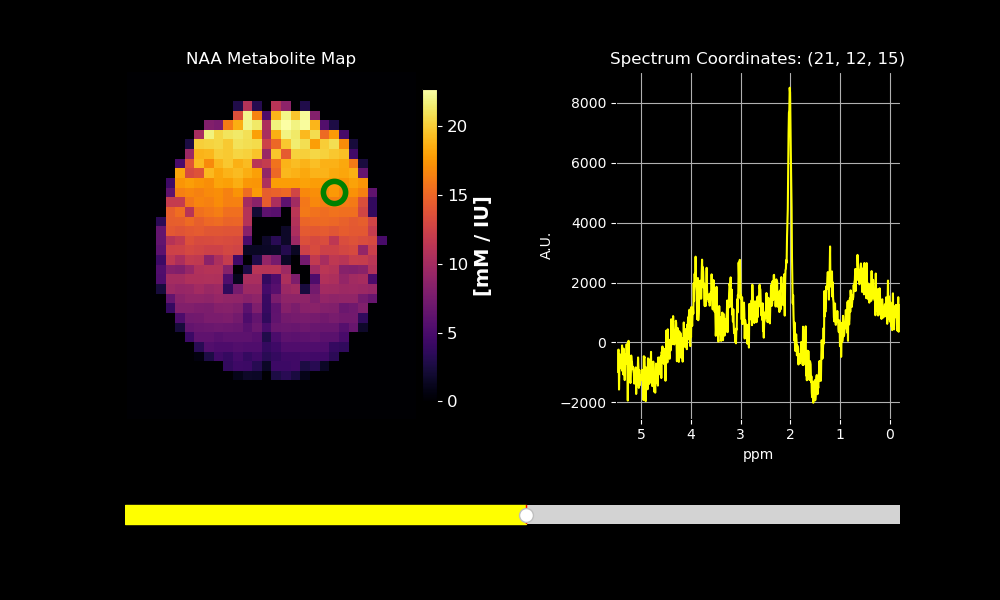

In [10]:
# Make sure plots can be used interactively
%matplotlib widget

metab_map = phantom.create_metab_map(metab='NAA')
reduced_metab_map, _ = downsample_metab_map(metab_map, phantom.affine, target_resolution=target_resolution)
fig, axs = plot_mrsi(reduced_data, reduced_metab_map, ppm_axis, metab_name='NAA', start_x=21, start_y=12)


## References
[1] [Gudmundson AT, Koo A, Virovka A, et al. Meta-analysis and open-source database for in vivo brain Magnetic Resonance spectroscopy in health and disease. Analytical Biochemistry. 2023;676:115227](https://doi.org/10.1016/j.ab.2023.115227)

[2] [Clarke WT, Stagg CJ, Jbabdi S. FSL-MRS: An end-to-end spectroscopy analysis package. Magnetic Resonance in Medicine. 2021;85(6):2950-2964.](https://doi.org/10.1002/mrm.28630)

[3] [Clarke WT, Bell TK, Emir UE, et al. NIfTI-MRS: A standard data format for magnetic resonance spectroscopy. Magnetic Resonance in Medicine. 2022;88(6):2358-2370](https://doi.org/10.1002/mrm.29418)
